In [1]:
import numpy as np
import tensorly as tl
from tqdm import tqdm
import tensor_filter as tf
import matplotlib.pyplot as plt

Using numpy backend.


In [2]:
# Functions for simulation of a full channel model.
def channel(number_of_antenas,number_of_users,number_of_paths,buffer_size):
    
    #Wavelength of the Carrier.
    l = 1
    #Speed of light
    c = 3**8
    #Symbol Period.    
    T = 10**-5
    #Wavelength of the Carrier.
    
    channel_gain = np.random.randn(number_of_users,number_of_paths)/np.sqrt(2) + 1j*np.random.randn(number_of_users,number_of_paths)/np.sqrt(2)
    channel_gain = (channel_gain - np.mean(channel_gain))/np.std(channel_gain)

    angles_of_arrival = -np.pi/2 + np.pi*np.random.rand(number_of_users,number_of_paths)
    channel_spatial_response = np.zeros([number_of_users,number_of_paths,number_of_antenas],dtype = 'complex')
    for i in range(0,number_of_users):
        for j in range(0,number_of_paths):
            for k in range(0,number_of_antenas):
                channel_spatial_response[i,j,k] = np.exp(-1j*np.pi*(k)*np.cos(angles_of_arrival[i,j]))
                 
    delay_response =  l/(2*c*np.cos(angles_of_arrival))
    pulse_shaping_waveform = np.zeros([number_of_users,number_of_paths,buffer_size],dtype = 'complex')
    for i in range(0,number_of_users):
        for j in range(0,number_of_paths):
            for k in range(0,buffer_size):
                pulse_shaping_waveform[i,j,k] = np.sinc(i*T - delay_response[i,j]) + 1j*np.sinc(k*T - delay_response[i,j])
                
    channel_tensor = np.zeros([number_of_users,number_of_paths,number_of_antenas,buffer_size],dtype = 'complex')
    for i in range(0,number_of_users):
        for j in range(0,number_of_paths):
            csr = (channel_spatial_response[i,j])[:,None]
            psw = (pulse_shaping_waveform[i,j])[:,None]
            channel_tensor[i,j] = channel_gain[i,j]*csr@psw.T
            
    channel_tensor = np.sum(channel_tensor,1)
    channel_matrix = tl.unfold(channel_tensor,1)
    
    return channel_matrix,channel_tensor

In [3]:
def sampled_signal(user_signal,number_of_users,buffer_size,instant_of_sampling):

    user_signal_at_k = np.zeros([number_of_users,buffer_size],dtype = 'complex')
    
    #This block simulates the change of signal throughout time in the buffer of data.
    for i in range(0,number_of_users):
        signal = user_signal[:,i]
        signal = signal[:,np.newaxis]
        signal = np.append(signal,np.zeros([1,buffer_size]))
        signal = signal[instant_of_sampling:instant_of_sampling+buffer_size]
        signal = (signal[::-1])
        user_signal_at_k[i,:] = signal
    
    return user_signal_at_k

def sampled_matrix(user_signal,number_of_users,number_of_antenas,buffer_size,lenght):
    
    matrix_of_sampling = tl.tensor(np.zeros([lenght,buffer_size,number_of_users],dtype = 'complex'))

    for j in range(0,number_of_users):
        for i in range(0,lenght):
            user_at_instant_i = sampled_signal(user_signal,number_of_users,buffer_size,i)
            matrix_of_sampling[i,:,j] = user_at_instant_i[j,:]

    matrix_of_sampling = np.transpose(matrix_of_sampling)
    matrix_of_sampling_tensor = matrix_of_sampling
    matrix_of_sampling = tl.unfold(matrix_of_sampling,2)
    
    return matrix_of_sampling, matrix_of_sampling_tensor

In [4]:
def noise(signal_uncorrupted,snr_dB):
    
    snr_linear = 10**(snr_dB/10)
    b = (1/2*snr_linear)*(np.random.randn(*signal_uncorrupted.shape) + np.random.randn(*signal_uncorrupted.shape))
    signal_corrupted = signal_uncorrupted + b

    return signal_corrupted, np.var(b)

def received_signal(matrix_of_sampling,channel_matrix,snr_dB):
   
    signal_uncorrupted = channel_matrix@np.transpose(matrix_of_sampling)
    [signal_corrupted,var_noise] = noise(signal_uncorrupted,snr_dB)
        
    return signal_uncorrupted,signal_corrupted,var_noise

In [48]:
def lms(signal_corrupted, signal, step, order):

    # Number of loops to count because of the buffer delay.
    I = signal_corrupted.size - order + 1
    # Filter output.
    signal_approx = np.zeros([I, 1], dtype = 'complex')
    # Error vector.
    error = np.zeros((I, 1), dtype = 'complex')
    # Matrix that will store the filter coeficients for each loop.
    w = np.zeros((order, I), dtype = 'complex')

    mse = np.zeros(I,)
    for i in range(I):
        u = np.flipud(signal_corrupted[i:i + order])[:, np.newaxis]
        signal_approx[i] = w[:, [i - 1]].T.conj() @ u
        error[i] = signal[i + order - 1] - signal_approx[i]
        mse[i] = np.absolute(error[i]) ** 2 / I

        # Updating the filter coeficients
        w[:, [i]] = w[:, [i - 1]] + step * u * (error[i].conj())
        signal_approx[i] = w[:, [i]].T.conj() @ u
    
    return mse

In [146]:
number_of_users = 1

step = 0.05
order = 2
lenght = 100

runs = 1000
MSE = np.zeros(lenght - order + 1)
for i in tqdm(range(runs)):
    signal = np.random.randint(2,size = [lenght,number_of_users]) + 1j*np.random.randint(2,size = [lenght,number_of_users])
    signal.real[signal.real == 0] = -1
    signal.imag[signal.imag == 0] = -1
    signal_corrupted = np.random.randn(1)*signal
    signal_corrupted = signal_corrupted[:,0]
    mse = lms(signal_corrupted, signal, step, order)

    MSE = MSE + mse
    
MSE = MSE/runs

100%|██████████| 1000/1000 [00:03<00:00, 276.49it/s]


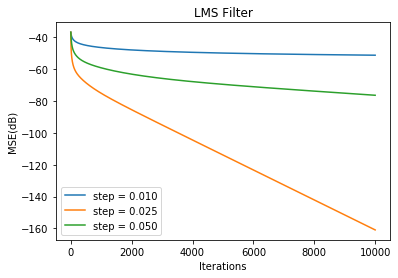

In [147]:
plt.figure()
plt.plot(10*np.log10(np.abs(MSE001)), label='step = 0.010')
plt.plot(10*np.log10(np.abs(MSE025)), label='step = 0.025')
plt.plot(10*np.log10(np.abs(MSE005)), label='step = 0.050')
plt.title('LMS Filter')
plt.ylabel('MSE(dB)')
plt.xlabel('Iterations')
plt.legend()
plt.savefig('LMS Filter - MSE x Iteration')
plt.show()

In [5]:
def nlms(signal_corrupted, signal, step, order):

    # Number of loops to count because of the buffer delay.
    I = signal_corrupted.size - order + 1
    # Filter output.
    signal_approx = np.zeros([I, 1], dtype = 'complex')
    # Error vector.
    error = np.zeros((I, 1), dtype = 'complex')
    # Matrix that will store the filter coeficients for each loop.
    w = np.zeros((order, I), dtype = 'complex')

    mse = np.zeros(I,)
    for i in range(I):
        u = np.flipud(signal_corrupted[i:i + order])[:, np.newaxis]
        signal_approx[i] = w[:, [i - 1]].T.conj() @ u
        error[i] = signal[i + order - 1] - signal_approx[i]
        mse[i] = np.absolute(error[i]) ** 2 / I

        # Updating the filter coeficients
        w[:, [i]] = w[:, [i - 1]] + (step / np.linalg.norm(u)) * u * (error[i].conj())
        signal_approx[i] = w[:, [i]].T.conj() @ u
    
    return mse

In [13]:
number_of_users = 1

step = 0.050
order = 1
lenght = 10000

runs = 100
MSE = np.zeros(lenght - order + 1)
for i in tqdm(range(runs)):
    signal = np.random.randint(2,size = [lenght,number_of_users]) + 1j*np.random.randint(2,size = [lenght,number_of_users])
    signal.real[signal.real == 0] = -1
    signal.imag[signal.imag == 0] = -1
    signal_corrupted = np.random.randn(1)*signal
    signal_corrupted = signal_corrupted[:,0]
    mse = nlms(signal_corrupted, signal, step, order)

    MSE = MSE + mse
    
MSE = MSE/runs

100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


In [14]:
MSE0050 = MSE

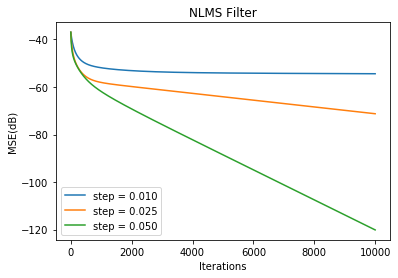

In [15]:
plt.figure()
plt.plot(10*np.log10(np.abs(MSE0010)), label='step = 0.010')
plt.plot(10*np.log10(np.abs(MSE0025)), label='step = 0.025')
plt.plot(10*np.log10(np.abs(MSE0050)), label='step = 0.050')
#plt.plot(10*np.log10(np.abs(MSE010)), label='step = 0.10')
#plt.plot(10*np.log10(np.abs(MSE020)), label='step = 0.20')
plt.title('NLMS Filter')
plt.ylabel('MSE(dB)')
plt.xlabel('Iterations')
plt.legend()
plt.savefig('NLMS Filter - MSE x Iteration')
plt.show()

In [148]:
def tlms(signal_corrupted, signal, step):
    _, sample = signal_corrupted.shape
    nh = 10
    nv = 10
    w_h = np.zeros([nh, 1])
    w_h[0] = 1
    w_v = np.zeros([nv, 1])
    w_v[0] = 1

    mse = np.zeros(sample)
    for i in range(0, sample):
        x = signal_corrupted[:, i]
        x_matrix = x.reshape([nh, nv], order = 'F')
        u_h = x_matrix @ (w_v.conj())
        u_v = x_matrix.T @ (w_h.conj())
        error = signal[i,] - (tl.tenalg.kronecker([w_v, w_h]).T.conj()) @ x
        step_approx = step / (np.linalg.norm(u_h, 2) ** 2 + np.linalg.norm(u_v, 2) ** 2)
        w_h = w_h + step_approx * u_h * error.conj()
        w_v = w_v + step_approx * u_v * error.conj()
        w = tl.tenalg.kronecker([w_v, w_h])
        mse[i] = ((np.absolute(signal[i,] - w.T.conj() @ x)) ** 2 ) / sample
        
    return w, mse

In [160]:
number_of_antenas = 100
number_of_users = 1
number_of_paths = 4
buffer_size = 16
lenght = 10000
snr_dB = 30
step = 0.05

runs = 100
MSE = np.zeros(lenght)
for i in tqdm(range(runs)):
    signal = np.random.randint(2,size = [lenght,number_of_users]) + 1j*np.random.randint(2,size = [lenght,number_of_users])
    signal.real[signal.real == 0] = -1
    signal.imag[signal.imag == 0] = -1
    [channel_matrix, _] = channel(number_of_antenas, number_of_users, number_of_paths, buffer_size)
    [matrix_of_sampling, _] = sampled_matrix(signal, number_of_users, number_of_antenas, buffer_size, lenght)
    [_, signal_corrupted, _] = received_signal(matrix_of_sampling, channel_matrix, snr_dB)
    [w, mse] = tlms(signal_corrupted, signal, step)
    
    MSE = MSE + mse
    
MSE = MSE/runs

100%|██████████| 100/100 [03:51<00:00,  2.31s/it]


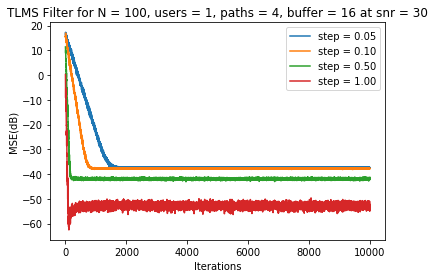

In [162]:
plt.figure()
plt.plot(10*np.log10(np.abs(MSE005)), label='step = 0.05')
plt.plot(10*np.log10(np.abs(MSE010)), label='step = 0.10')
plt.plot(10*np.log10(np.abs(MSE050)), label='step = 0.50')
plt.plot(10*np.log10(np.abs(MSE100)), label='step = 1.00')
plt.title('TLMS Filter for N = 100, users = 1, paths = 4, buffer = 16 at snr = 30')
plt.ylabel('MSE(dB)')
plt.xlabel('Iterations')
plt.legend()
plt.savefig('TLMS Filter - MSE x Iteration')
plt.show()

In [190]:
def atlms(signal_corrupted, signal, step):
    
    _, sample = signal_corrupted.shape
     
    Kh = 10
    Kv = 10
    Kb = np.floor(sample/(Kh + Kv))
   
    w_h = np.zeros([Kh, 1])
    w_h[0] = 1
    w_v = np.zeros([Kv, 1])
    w_v[0] = 1
    
    z = 0
    mse = np.zeros(sample)
    for i in range(0,int(Kb*(Kh + Kv)), int(Kh + Kv)):
        
        for j in range(i,int(i + Kh)):
            x = signal_corrupted[:, j]
            x_matrix = x.reshape([Kh, Kv], order = 'F')
            u_h = x_matrix @ (w_v.conj())
            error = signal[j,] - (tl.tenalg.kronecker([w_v, w_h]).T.conj()) @ x
            step_approx = step / (np.linalg.norm(u_h, 2) ** 2)
            w_h = w_h + step_approx * u_h * error.conj()
            w = tl.tenalg.kronecker([w_v, w_h])
            mse[z] = np.absolute(error) ** 2 / sample
            z = z + 1
            
        for k in range(int(i + Kh),int(i + Kh + Kv)):
            x = signal_corrupted[:, k]
            x_matrix = x.reshape([Kh, Kv], order = 'F')
            u_v = x_matrix.T @ (w_h.conj())
            error = signal[k,] - (tl.tenalg.kronecker([w_v, w_h]).T.conj()) @ x
            step_approx = step / (np.linalg.norm(u_v, 2) ** 2)
            w_v = w_v + step_approx * u_v * error.conj()
            w = tl.tenalg.kronecker([w_v, w_h])
            mse[z] = np.absolute(error) ** 2 / sample
            z = z + 1
            
    return w, mse

In [179]:
number_of_antenas = 100
number_of_users = 1
number_of_paths = 4
buffer_size = 16
lenght = 10000
snr_dB = 30
step = 0.05

runs = 100
MSE = np.zeros(lenght)
for i in tqdm(range(runs)):
    signal = np.random.randint(2,size = [lenght,number_of_users]) + 1j*np.random.randint(2,size = [lenght,number_of_users])
    signal.real[signal.real == 0] = -1
    signal.imag[signal.imag == 0] = -1
    [channel_matrix, _] = channel(number_of_antenas, number_of_users, number_of_paths, buffer_size)
    [matrix_of_sampling, _] = sampled_matrix(signal, number_of_users, number_of_antenas, buffer_size, lenght)
    [_, signal_corrupted, _] = received_signal(matrix_of_sampling, channel_matrix, snr_dB)
    [w, mse] = atlms(signal_corrupted, signal, step)
    
    MSE = MSE + mse
    
MSE = MSE/runs

100%|██████████| 100/100 [03:05<00:00,  1.85s/it]


In [180]:
MSE005 = MSE

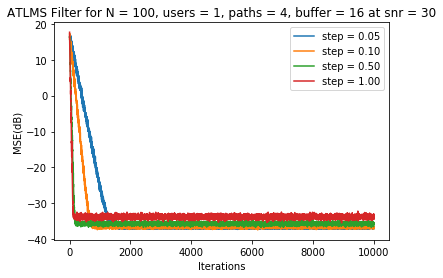

In [182]:
plt.figure()
plt.plot(10*np.log10(np.abs(MSE005)), label='step = 0.05')
plt.plot(10*np.log10(np.abs(MSE010)), label='step = 0.10')
plt.plot(10*np.log10(np.abs(MSE050)), label='step = 0.50')
plt.plot(10*np.log10(np.abs(MSE100)), label='step = 1.00')
plt.title('ATLMS Filter for N = 100, users = 1, paths = 4, buffer = 16 at snr = 30')
plt.ylabel('MSE(dB)')
plt.xlabel('Iterations')
plt.legend()
plt.savefig('ATLMS Filter - MSE x Iteration for Kh = Kv = 10')
plt.show()